## Introduction

The goal of this project is to introduce methods for modeling Gaussian Processes (GP) whose underlying function values (priors) are treated as latent variables. For the sake of this example, we will be using PyMC3's Gaussian Process function along with the [`gp.Latent`](https://docs.pymc.io/en/latest/api/gp/generated/pymc.gp.Latent.html?highlight=pymc.gp.Latent) class. This class includes a [`prior`](https://docs.pymc.io/en/latest/api/gp/generated/classmethods/pymc.gp.Latent.prior.html?highlight=pymc.gp.Latent.prior) and [`conditional`](https://docs.pymc.io/en/latest/api/gp/generated/classmethods/pymc.gp.Latent.conditional.html?highlight=pymc.gp.Latent.conditional) method that are used to construct random variables representing the unknown function whose distribution is the GP prior or GP conditional. This GP implementation can be used to implement regression on data that is not normally distributed. The GP function, f(x), can be modeled as:

$$
f(x) \sim GP(m(x), k(x, x'))
$$

Where $ m(x) $ is our mean function and $ k(x, x') $ is our covariance (kernel) function.

Both the mean and covariance functions default to zero, however; the [covariance function](https://docs.pymc.io/en/v3/api/gp/cov.html) can be set to any of the following:

| Function    |     Description     |
| ----------- | -----------------   |
| Constant(c) | Constant valued covariance function. |
| WhiteNoise(sigma) | White noise covariance function. |
| ExpQuad(input_dim[, ls, ls_inv, active_dims]) | The Exponentiated Quadratic kernel. |
| RatQuad(input_dim, alpha[, ls, ls_inv, ...]) | The Rational Quadratic kernel. |
| Matern32(input_dim[, ls, ls_inv, active_dims]) | The Matern kernel with nu = 3/2. |
| Matern52(input_dim[, ls, ls_inv, active_dims]) | The Matern kernel with nu = 5/2. |
| Exponential(input_dim[, ls, ls_inv, active_dims]) | The Exponential kernel. |
| Cosine(input_dim[, ls, ls_inv, active_dims]) | The Cosine kernel. |
| Periodic(input_dim, period[, ls, ls_inv, ...]) | The Periodic kernel. |
| Linear(input_dim, c[, active_dims]) | The Linear kernel. |
| Polynomial(input_dim, c, d, offset[, ...]) | The Polynomial kernel. |
| WarpedInput(input_dim, cov_func, warp_func) | Warp the inputs of any kernel using an arbitrary function defined using Theano. |
| Gibbs(input_dim, lengthscale_func[, args, ...])| The Gibbs kernel. |
| Kron(factor_list) | Form a covariance object that is the kronecker product of other covariances. |
| Coregion(input_dim[, W, kappa, B, active_dims]) | Covariance function for intrinsic/linear coregionalization models. |

## Priors

The `prior` method places a multivariate normal prior distribution on the vector of function values, $ f $. This can be written as:

$$
f \sim MvNormal(m_x, K_{xx})
$$

where the vector $ m $ and the matrix $ K_{xx} $ are the mean vector and covariance matrix, respectively, evaluated over the inputs $ x $.

Since the function variables are considered to be latent, we aren't going to be explicitly setting them. Instead, we will initialize the mean and covariance functions. An example of this is shown below:

```python
import numpy as np
import pymc3 as pm

# A one dimensional column vector of inputs.
X = np.linspace(0, 1, 10)[:,None]

with pm.Model() as latent_gp_model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Latent(cov_func=cov_func)

    # Place a GP prior over the function f.
    f = gp.prior("f", X=X)
```

The last line of this code block is evaluating the initialized functions across all of the inputs, `X`, to return a vector of function values, $ f $. It is important to note that the GP function requires X to a one-dimensional column vector of inputs.

When running the prior across inputs `X`, PyMC3 also does some additional processing in the background. PyMC3 will reparameterize the prior by rotating it using Cholesky matrix factorization. Cholesky factorization decomopses a matrix into the product of a lower triangle matrix and its conjugate transpose -- which is useful for efficient numerical solutions. The resulting reparameterized model is:

$$
v \sim N(0,1) \\
L = Cholesky(L_{xx}) \\
f = m_x + Lv
$$

What is a "lower traingular matrix"? Assume we have some matrix, L, the lower triangle matrix would be all of the values to the left of, underneath, and including the diagonal. See example below.

$$ L =
\begin{bmatrix}
l_{1,1} & & & & 0 \\
l_{2,1} & l_{2,2} \\
l_{3,1} & l_{3,2} & \ddots \\
\vdots & \vdots & \ddots & \ddots \\
l_{n,1} & l_{n,2} & \dots & l_{n,n-1} & l_{n,n}
\end{bmatrix}
$$

What is the "conjugate transpose"? This is the process of first taking the transpose of a matrix, basically rotating it 90 degrees in a sense, and then taking the conjugate of every entry in the matrix. In our case, we actually need to take the complex conjugate, which introduces imaginary numbers:

- Assume we have the matrix $ A $
    - $ A = \begin{bmatrix} 1 & -2-i & 5 \\ 1+i & i & 4-2i \end{bmatrix} $
- We first transpose (rotate) the matrix:
    - $ A = \begin{bmatrix} 1 & 1+i \\ -2-i & i \\ 5 & 4-2i  \end{bmatrix} $
- Then we conjugate every element:
    - $ A = \begin{bmatrix} 1 & 1-i \\ -2+i & -i \\ 5 & 4+2i  \end{bmatrix} $

The resulting decomposition is typically written in the form $ A = LL^* $, where $ L $ indicates the lower triangular matrix and $ L^* $ is the conjugate transpose. See [this link](https://en.wikipedia.org/wiki/Cholesky_decomposition#:~:text=Online%20calculators-,Statement,-%5Bedit%5D) for more information.

## Conditional

The conditional method implements the predictive distribution for function values that were **not** part of the original dataset. This distribution is,

$$
f_* | f \sim MvNormal(m_* + K_{*x}K_{xx}^{-1}f,K_{**}-K_{*x}K_{xx}^{-1}K_{x*})
$$

This distribution is created using the values $ f $ that the GP prior was over, and is now the set of new points $ f_* $. Using this we can can construct a random variable with:

```python
# vector of new X points we want to predict the function at
X_star = np.linspace(0, 2, 100)[:, None]

with latent_gp_model:
    f_star = gp.conditional("f_star", X_star)
```


## Key Takeaways

1. We use `pymc.gp.Latent` for unknown function variables
2. `pymc.gp.Latent.prior` allows us to **fit** a model to a given dataset
3. `pymc.gp.Latent.conditional` allows us to **predict** and forecast values

---

## Creating a Generative Model

We start by defining a generative model whose data is influence by a Student-T distributed noise function.

In [141]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# mute future warnings from theano
warnings.simplefilter(action="ignore", category=FutureWarning)

We start by selecting how large of a dataset we would like to create. Next, we generate N-points, evenly spaced between a start and stop value.

In [53]:
n = 200  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector

Creating the covariance function is as simple as calling the covariance method of the GP class. Something to keep in mind: for $ f \sim GP(0, k) $, the correlation between $f(x)$ and $f(y)$ is exactly $k(x,y)$. The Matern kernel (generalization of RBF kernel) we use in this example takes a parameter tau and eta which are the input dimensions and length scale, respectively. It's important to know that with the selected kernel, any two points have a positive correlation, but that correlation goes to zero as you move farther away. The lengthscale parameter allows us to set the factor for how quickly the correlation of 2 variables goes to zero as they move apart. To put this practically, if you were to look at the popularity of a given president, the popularity at time $ t $ has a much greater impact on their popularity at time $ t+5 $ than it would at $ t+30 $.

In [54]:
# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

In [55]:
# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

We create a "true generating function", $ f $, that uses a multivariate normal distribution to generate data. The `pymc.gp.Latent.prior` method expects a multivariate normal distribution, so that is the distribution we use to generate our data. The generated data is then applied Student-T distributed noise. The final function, with the applied noise, is labeled $ y $.

In [56]:
# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

Text(0.5, 0, 'X')

Text(0, 0.5, 'y')

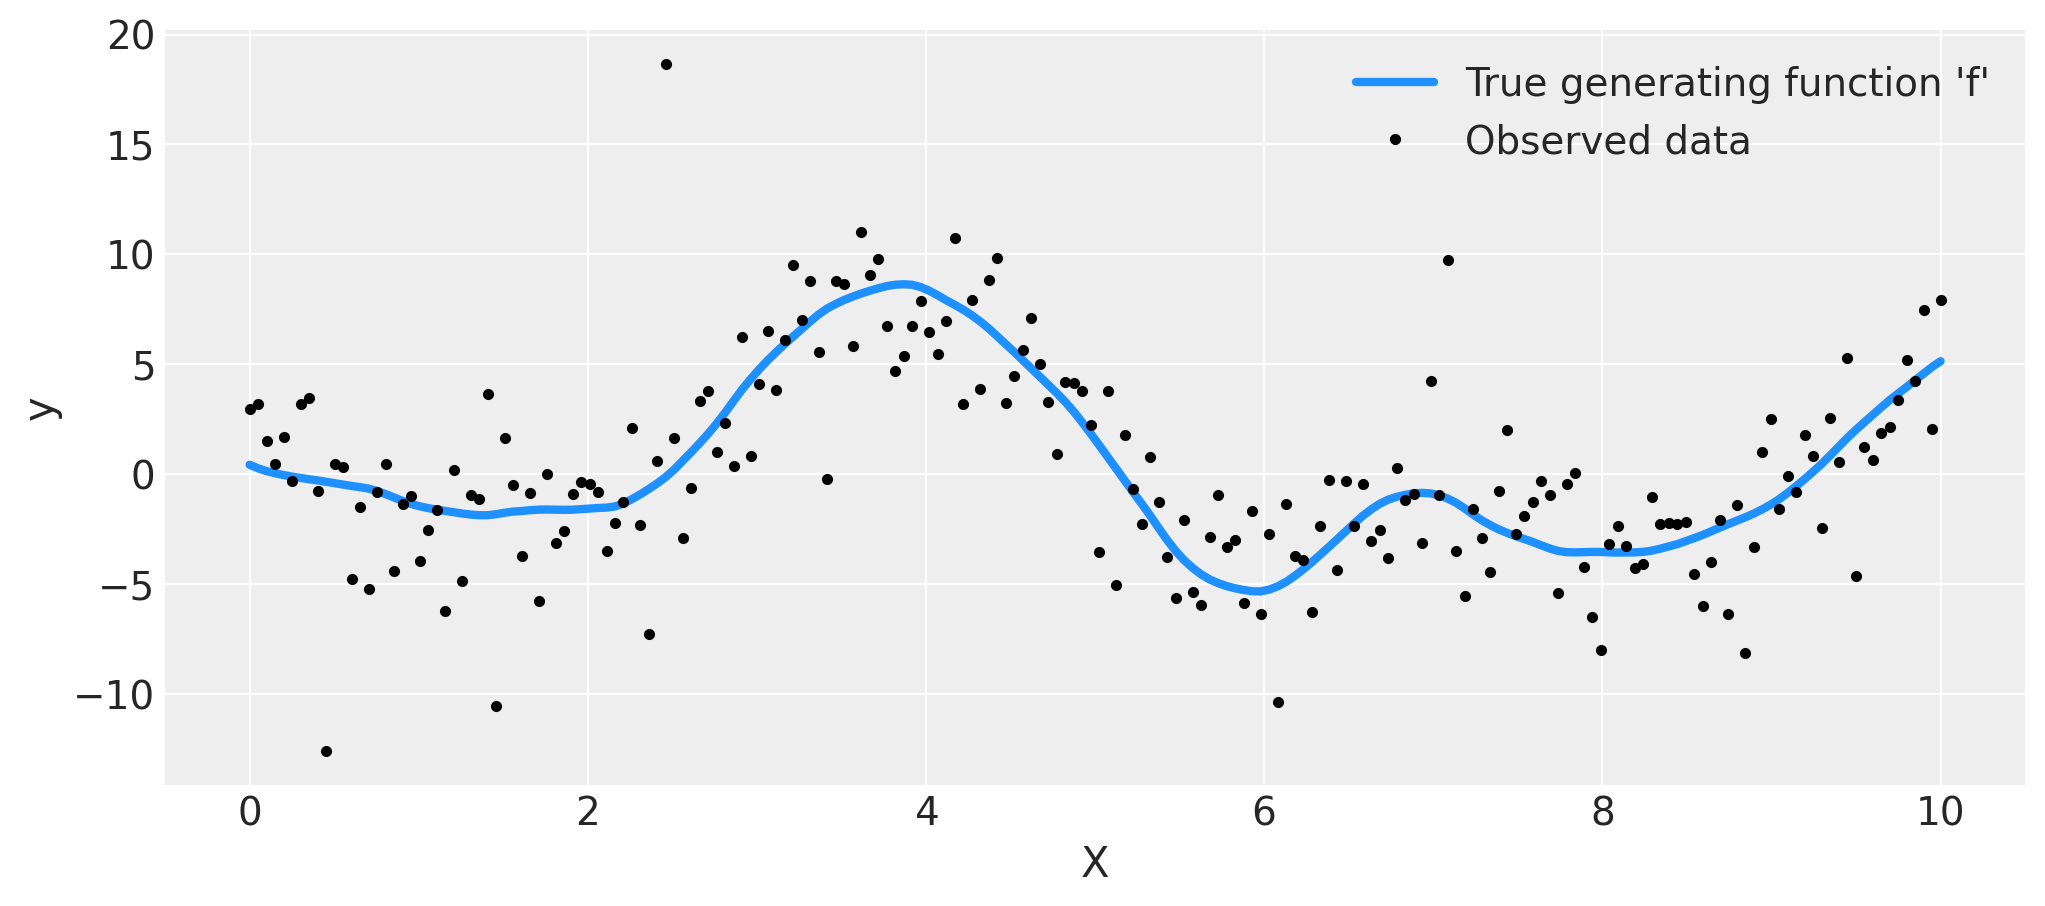

In [57]:
## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend()

Keep in mind: The model we create will not "see" this blue line. The blue line is a visualization of the function that generated the observed data points. Our goal is to work backwards and generate the blue line based on the observed data. This is what is meant when we talk about the underlying function variables being latent.

## Fit the Model

Since the entire purpose of this exercise is to determine the latent function variables (priors), we cannot do a prior predictive check.

Let's go ahead and define our model:

$$
f(x) \sim GP(m(x), k(x, x')) \\
ℓ \sim Gamma(alpha=2.0, beta=1.0) \\
η \sim HalfCauchy(beta = 1.0) \\
σ \sim HalfCauchy(beta = 5.0) \\
ν \sim Gamma(alpha = 2.0, beta = 0.1) \\
y \sim StudentT(nu = \nu, mu = f, lam = f(f(\sigma)))
$$

Starting from the top and working down:
1. The original GP function as shown above, takes a mean and covariance function.
2. Tau is the length scale parameter and follows a gamma distribution which represents the sum of `alpha` exponentially distributed random variables, each of which has rate `beta`.
3. Eta is used as the measure of effect size for our covariance function and uses a half-cauchy (Koh-shee) distribution.
4. Sigma is the scale of the noise function.
5. Nu is assigned to the degrees of freedom parameter of the Student-T noise function.
6. Y is the resulting generator function

In [58]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1) # length scale
    η = pm.HalfCauchy("η", beta=1) # eta

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ) # measure of effect size * covariance with input dim of 1 and length scale tau
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)

    trace = pm.sample(draws=1000, chains=2, cores=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, ℓ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 802 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [59]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(np.sum(az.rhat(trace)[["η", "ℓ", "f_rotated_"]].to_array() > 1.03).values)
print("%i MCMC chains have not converged." % n_nonconverged)

0 MCMC chains have not converged.


array([[<AxesSubplot:title={'center':'η'}>,
        <AxesSubplot:title={'center':'η'}>],
       [<AxesSubplot:title={'center':'ℓ'}>,
        <AxesSubplot:title={'center':'ℓ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

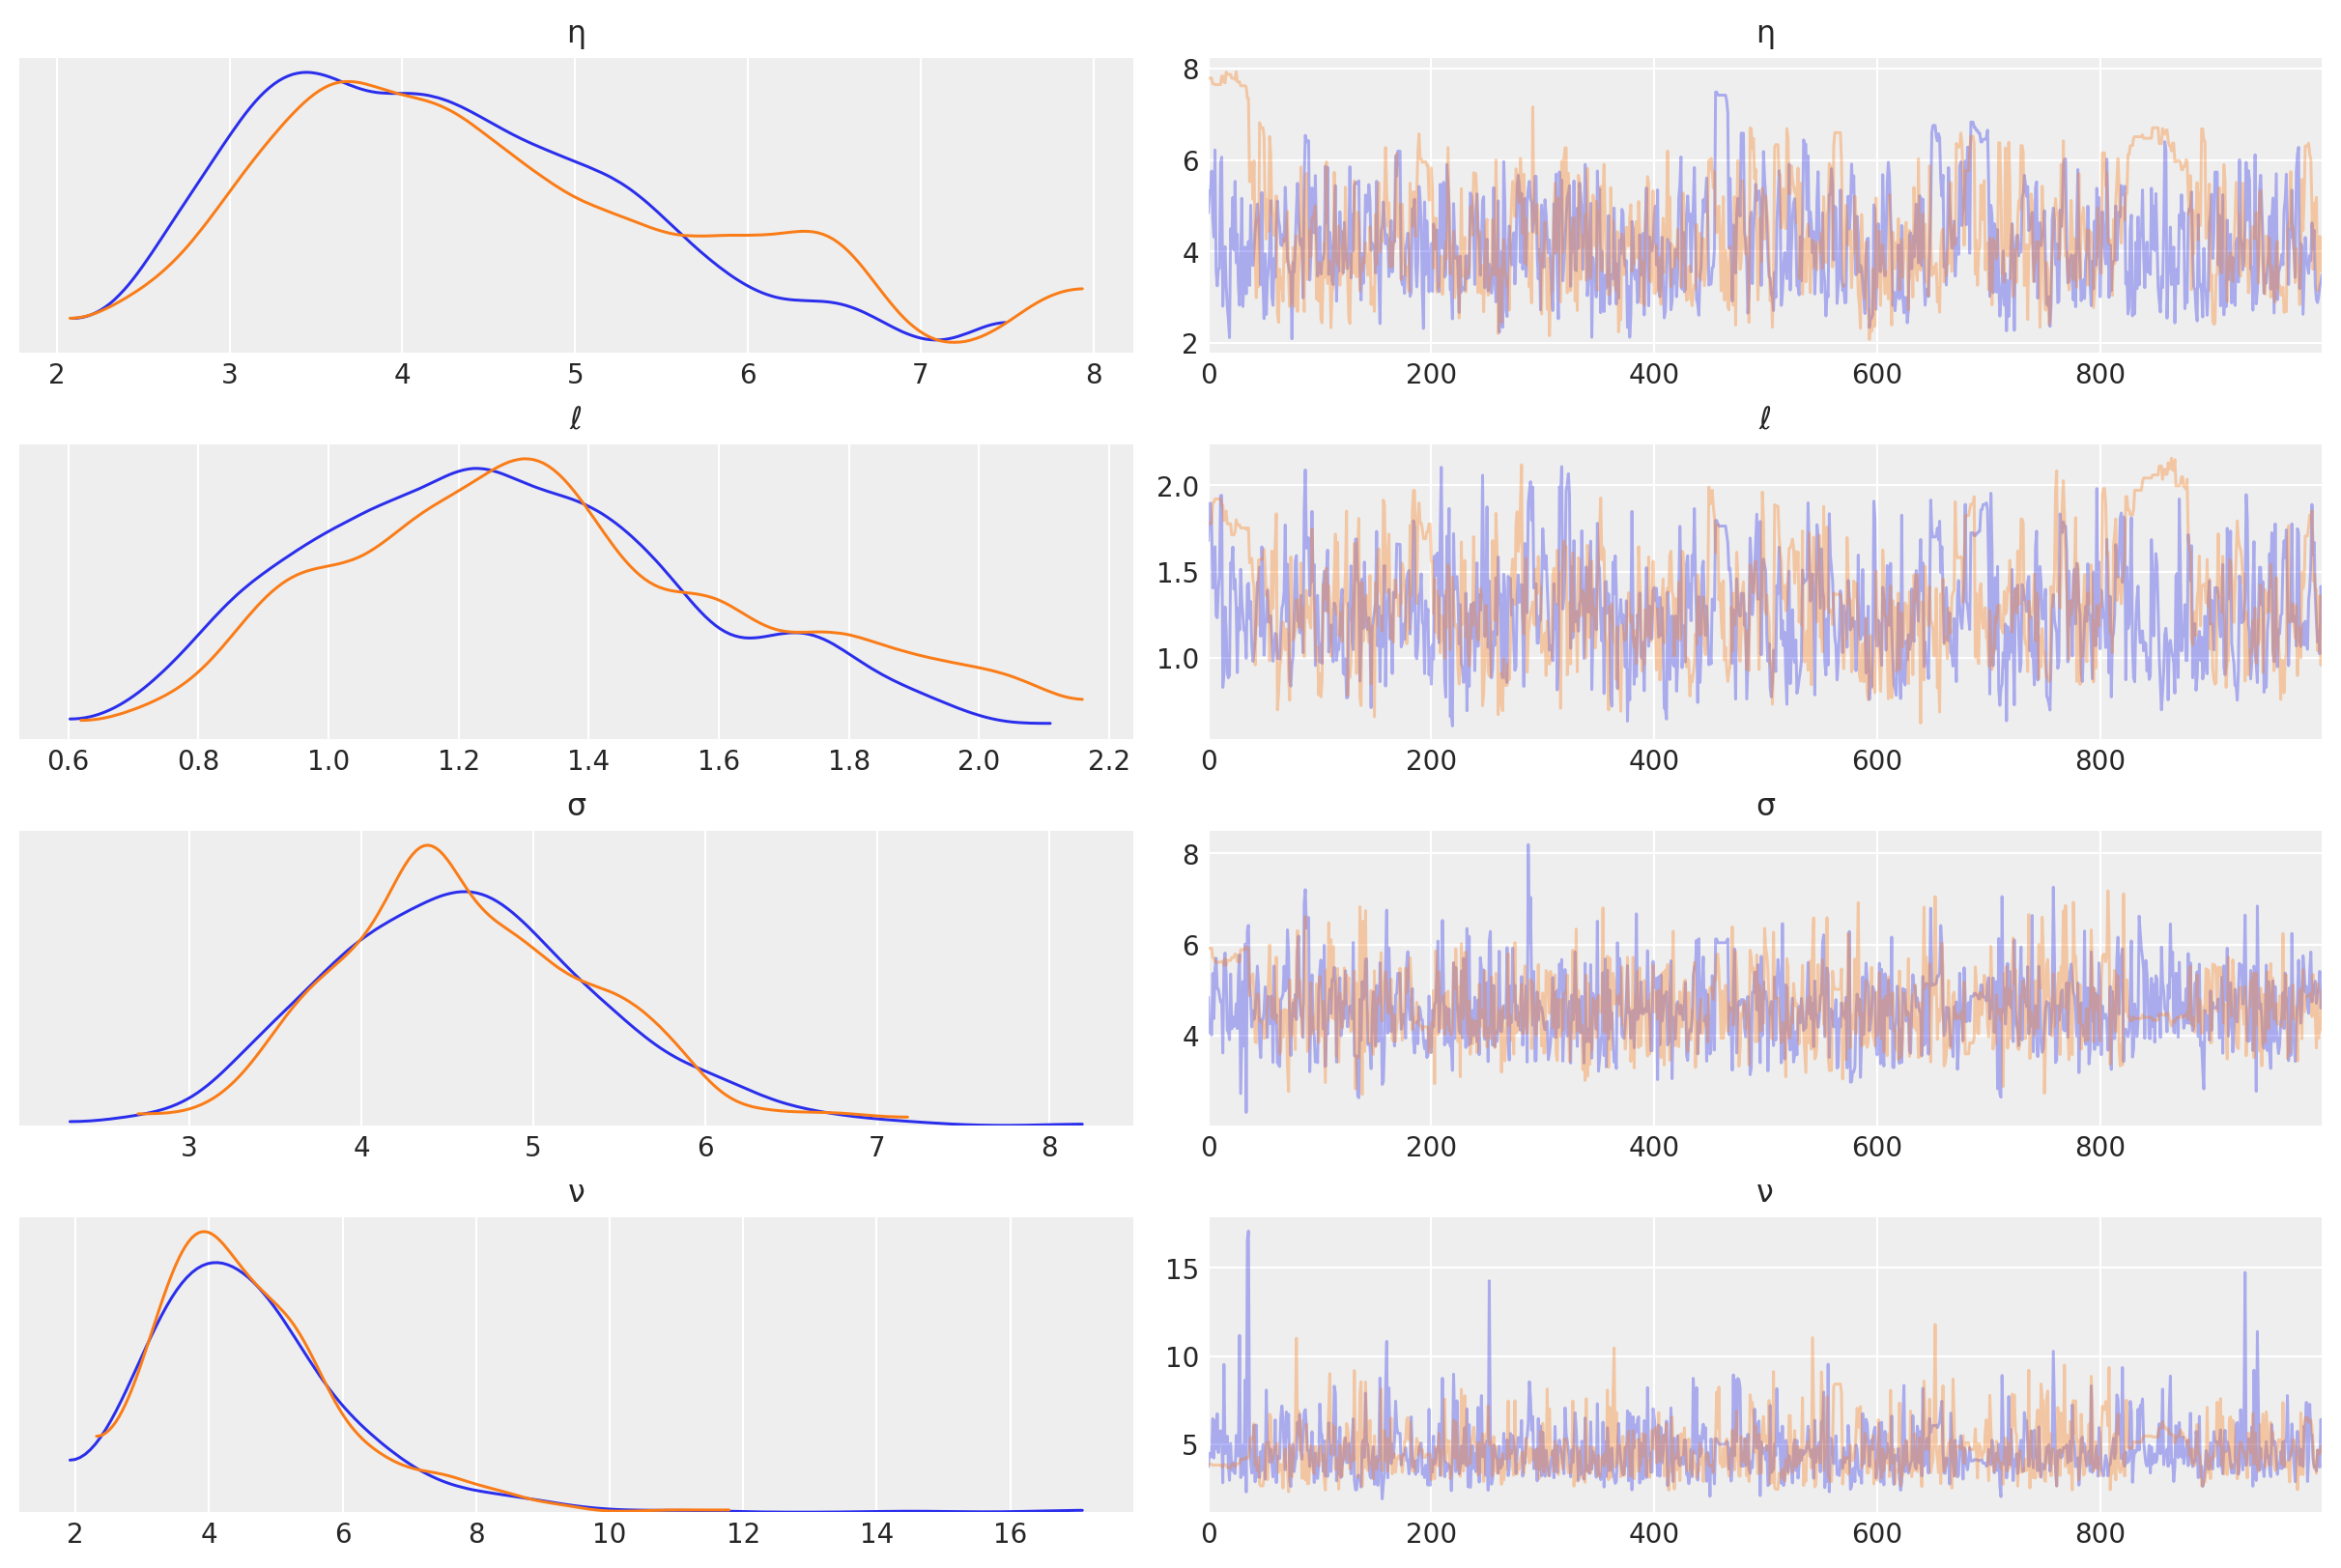

In [117]:
az.plot_trace(trace, var_names=["η", "ℓ", "σ", "ν"])

In [120]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
f_rotated_[0],0.476,0.265,-0.003,0.977,0.012,0.008,502.0,502.0,427.0,370.0,1.00
f_rotated_[1],-0.891,0.756,-2.235,0.596,0.023,0.017,1049.0,962.0,1053.0,1079.0,1.01
f_rotated_[2],-0.448,0.914,-2.154,1.218,0.041,0.029,498.0,498.0,505.0,728.0,1.00
f_rotated_[3],-0.326,0.978,-2.198,1.524,0.052,0.055,353.0,161.0,383.0,168.0,1.01
f_rotated_[4],-0.219,0.997,-2.020,1.671,0.031,0.026,1048.0,734.0,1036.0,1201.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
f[197],4.026,0.942,2.390,5.871,0.031,0.022,903.0,903.0,921.0,1345.0,1.00
f[198],4.241,1.041,2.405,6.216,0.037,0.026,775.0,775.0,783.0,1243.0,1.00
f[199],4.430,1.149,2.522,6.675,0.042,0.030,735.0,735.0,746.0,1174.0,1.00
σ,4.620,0.778,3.249,6.041,0.025,0.018,960.0,889.0,1036.0,825.0,1.00


## Joint Posterior

Below is the hexbin plot of the two covariance function hyperparameters. The red lines show the true values that were used to draw the function from the GP.

<AxesSubplot:xlabel='η', ylabel='ℓ'>

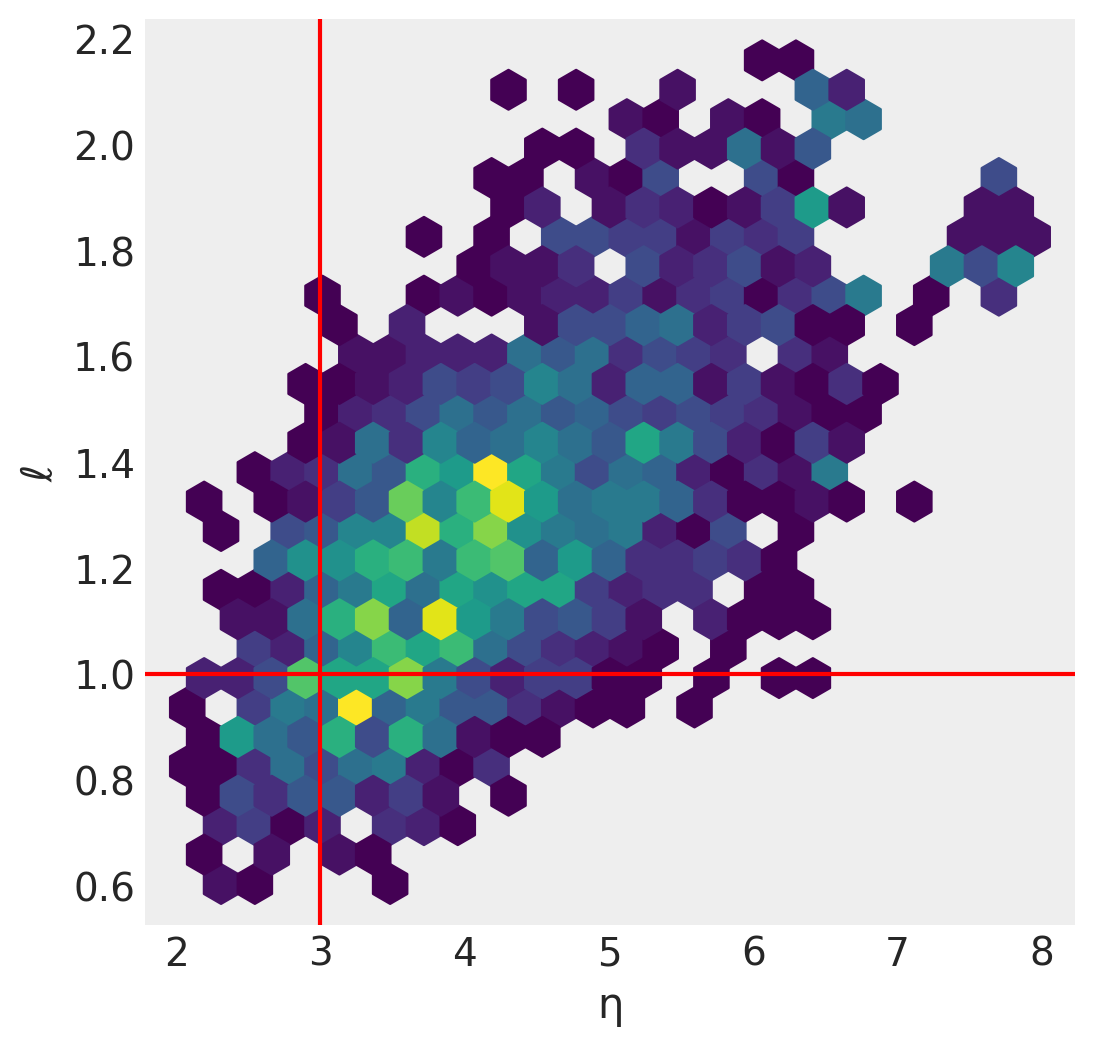

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

az.plot_pair(
    trace,
    var_names=["η", "ℓ"],
    kind=["hexbin"],
    ax=ax,
    gridsize=25,
    divergences=True,
)

ax.axvline(x=η_true, color="r")
ax.axhline(y=ℓ_true, color="r")

Below is the joint posterior of the hyperparameters of the Student-T noise function. Red indicates the values used to generate the data.

<AxesSubplot:xlabel='ν', ylabel='σ'>

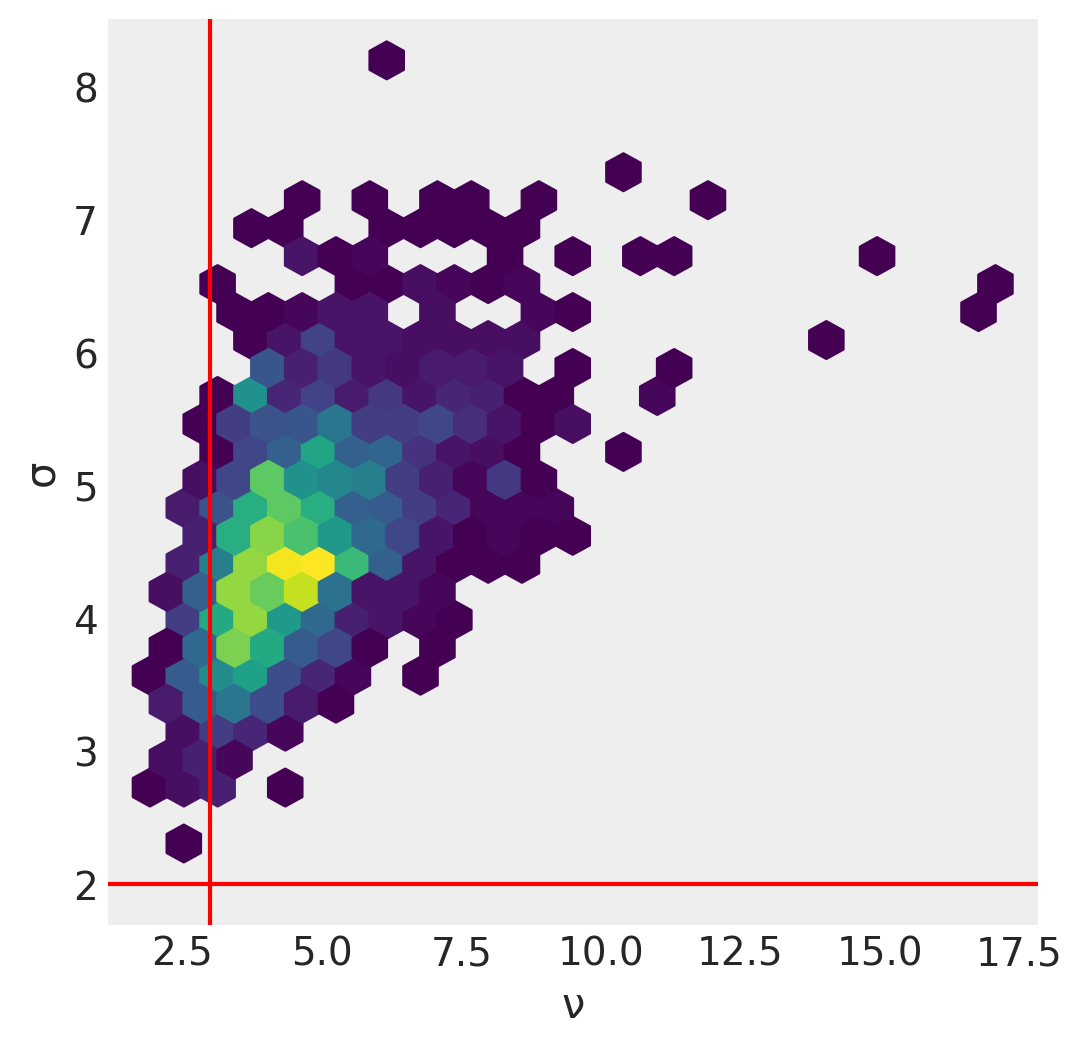

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

az.plot_pair(
    trace,
    var_names=["ν", "σ"],
    kind=["hexbin"],
    ax=ax,
    gridsize=25,
    divergences=True,
)

ax.axvline(x=ν_true, color="r")
ax.axhline(y=σ_true, color="r")

## Posterior Distribution

<AxesSubplot:>

Text(0.5, 0, 'X')

Text(0, 0.5, 'True f(x)')

Text(0.5, 1.0, 'Posterior distribution over $f(x)$ at the observed values')

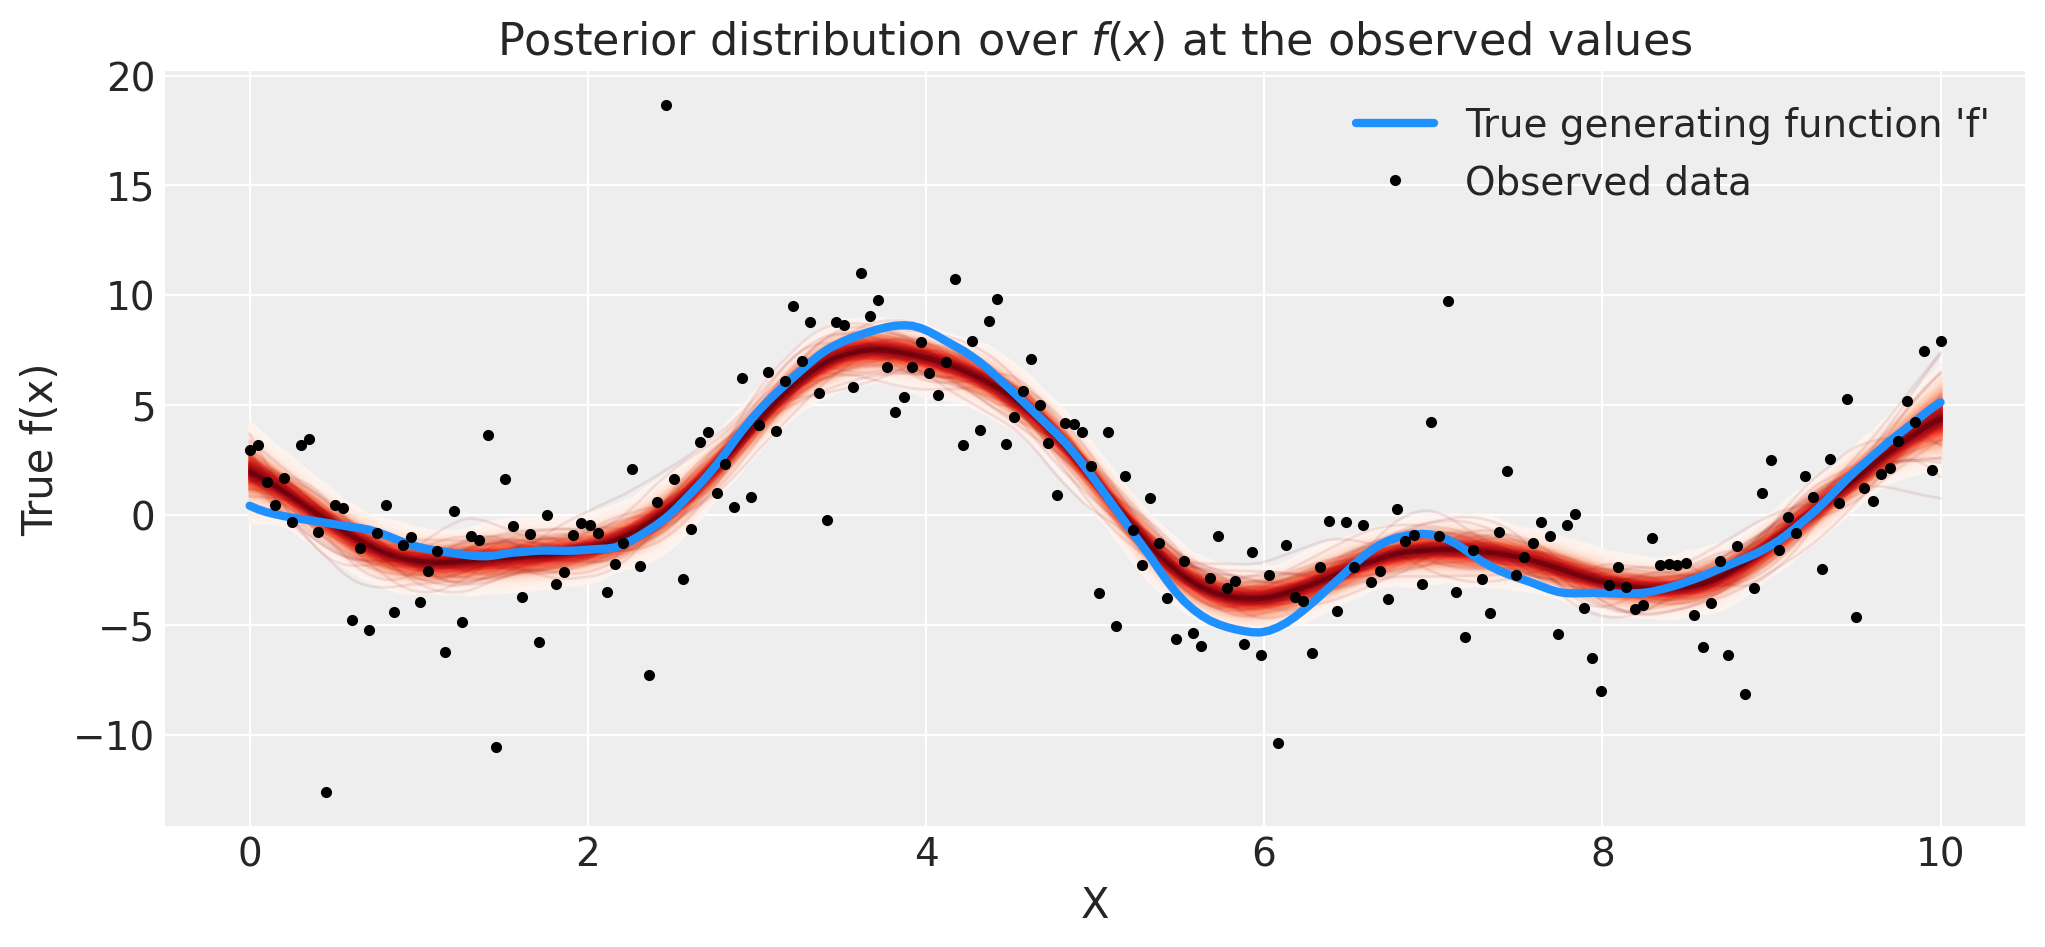

In [66]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend()

Remember, the Gaussian Process was not explicitly fed the blue line (true generating function). The GP instead was able to discover the latent hyperparameters used to generate such data. We can see that the GP did a really good job fitting the model and did not experience overfitting -- even where the Student-T noise function generated significant outliers.

## Predicting the Future: `Conditional`

Extending the previous example, we can use the `conditional` method to predict the next N-points by creating a new multivariate normal distribution over the generated priors. You may also hear this method referred to as "extrapolation," or otherwise, generating estimates under the assumption that the observed trends will continue.

In [67]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace.posterior, vars=[f_pred])

<AxesSubplot:>

Text(0.5, 0, 'X')

Text(0, 0.5, 'True f(x)')

Text(0.5, 1.0, 'Conditional distribution of f_*, given f')

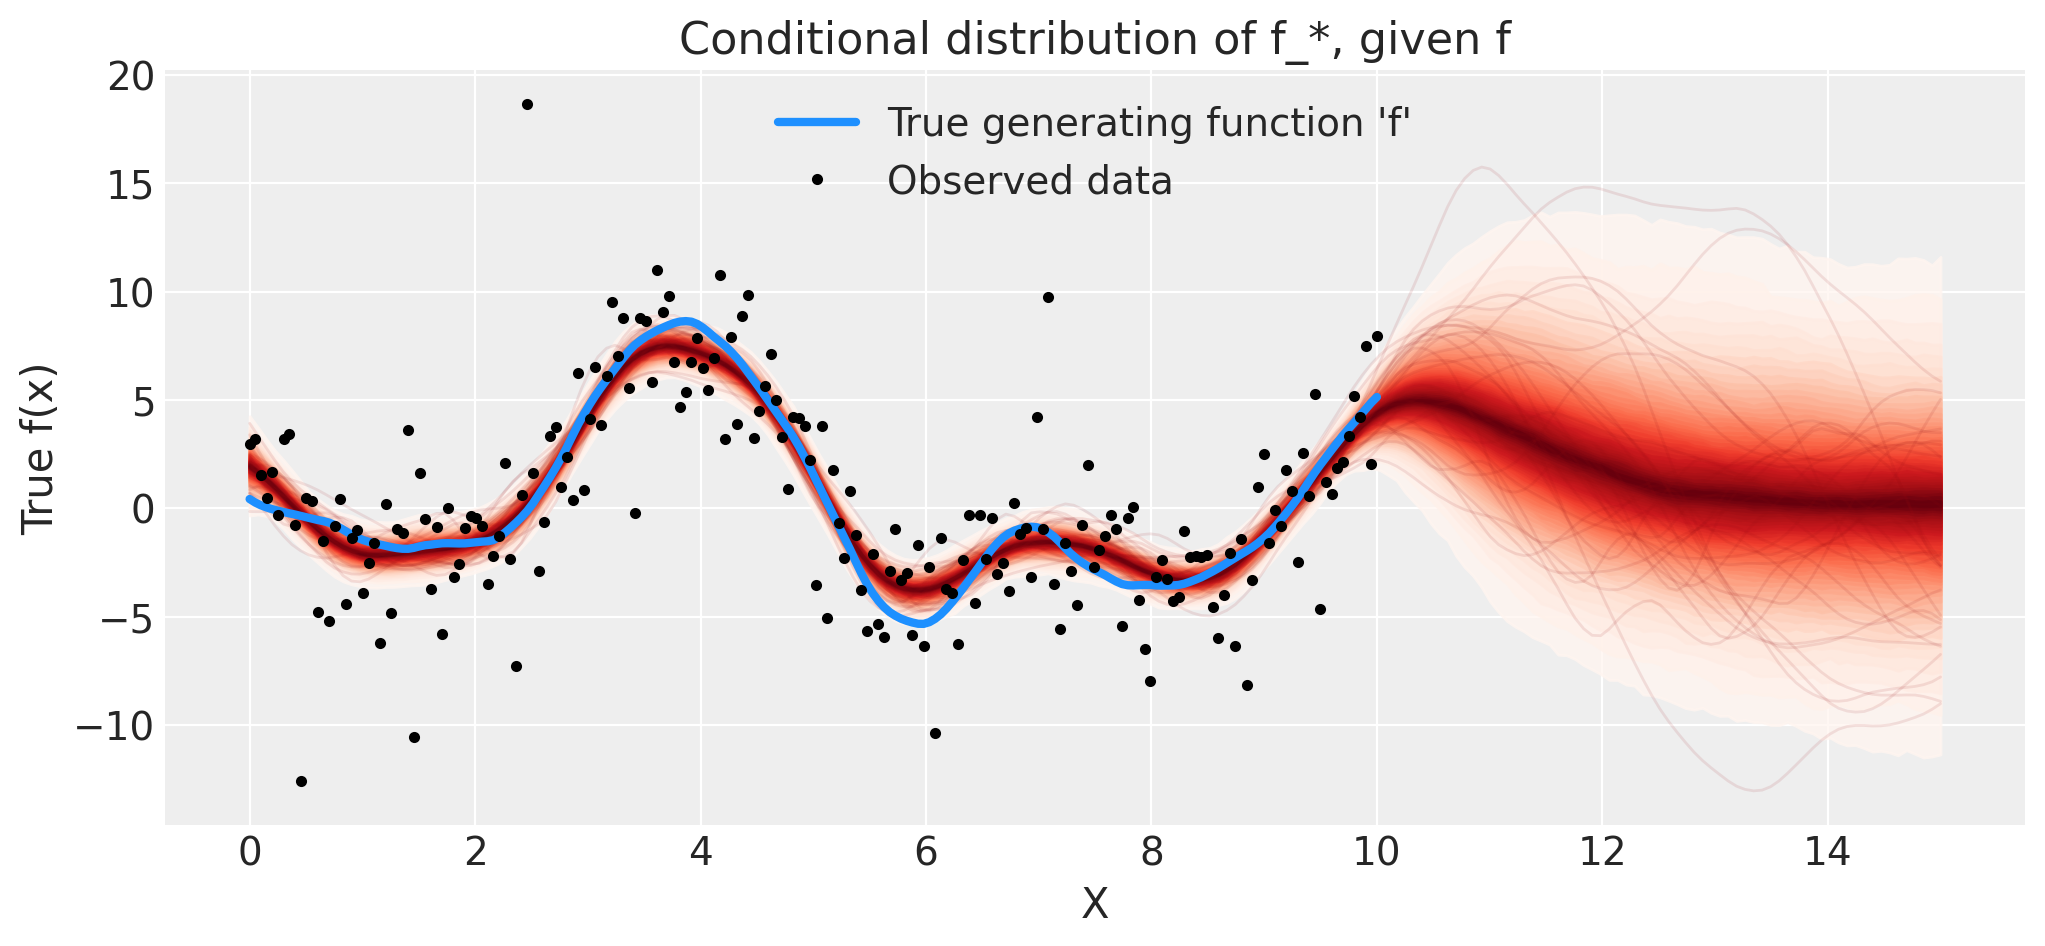

In [68]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new)

ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend()

---

## Marginal Likelihood Implementation

Alternatively, we could use the `pymc.gp.Marginal` class to generate similar predictions as above. This class has a `marginal_likelihood`, `conditional`, and `predict` method. The GP model is written the same as previously but now we are using the marginal likelihood function. This function can be written as:

$$
p(y|x) = \int p(y|f,x)p(f|x)df
$$

Subsequently, the log of the marginal likelihood can be written as:

$$
log p(y|x) = -\frac{1}{2}(y-m_x)^2(K_{xx}+\Sigma)^{-1}(y-m_x)-\frac{1}{2}\log{K_{xx} + \Sigma}-\frac{n}{2}\log{2\pi}
$$

The $\Sigma$ term is the covariance matrix of the Gaussian noise. Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using white noise or a covariance function.

## Fit the Model

In [145]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y2_ = gp.marginal_likelihood("y2", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

In [146]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame(
    {
        "Parameter": ["ℓ", "η", "σ"],
        "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])],
        "True value": [ℓ_true, η_true, σ_true],
    }
)

,Parameter,Value at MAP,True value
0,ℓ,1.577997,1.0
1,η,3.870034,3.0
2,σ,3.037648,2.0


## Conditional Prediciton

In [147]:
# 200 new values from x=0 to x=15
n_new = 200
X_new = np.linspace(0, 15, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f2_pred = gp.conditional("f2_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f2_pred], samples=2000)

<AxesSubplot:>

Text(0.5, 0, 'X')

Text(0, 0.5, 'True f(x)')

Text(0.5, 1.0, 'Conditional distribution of f_*, given f')

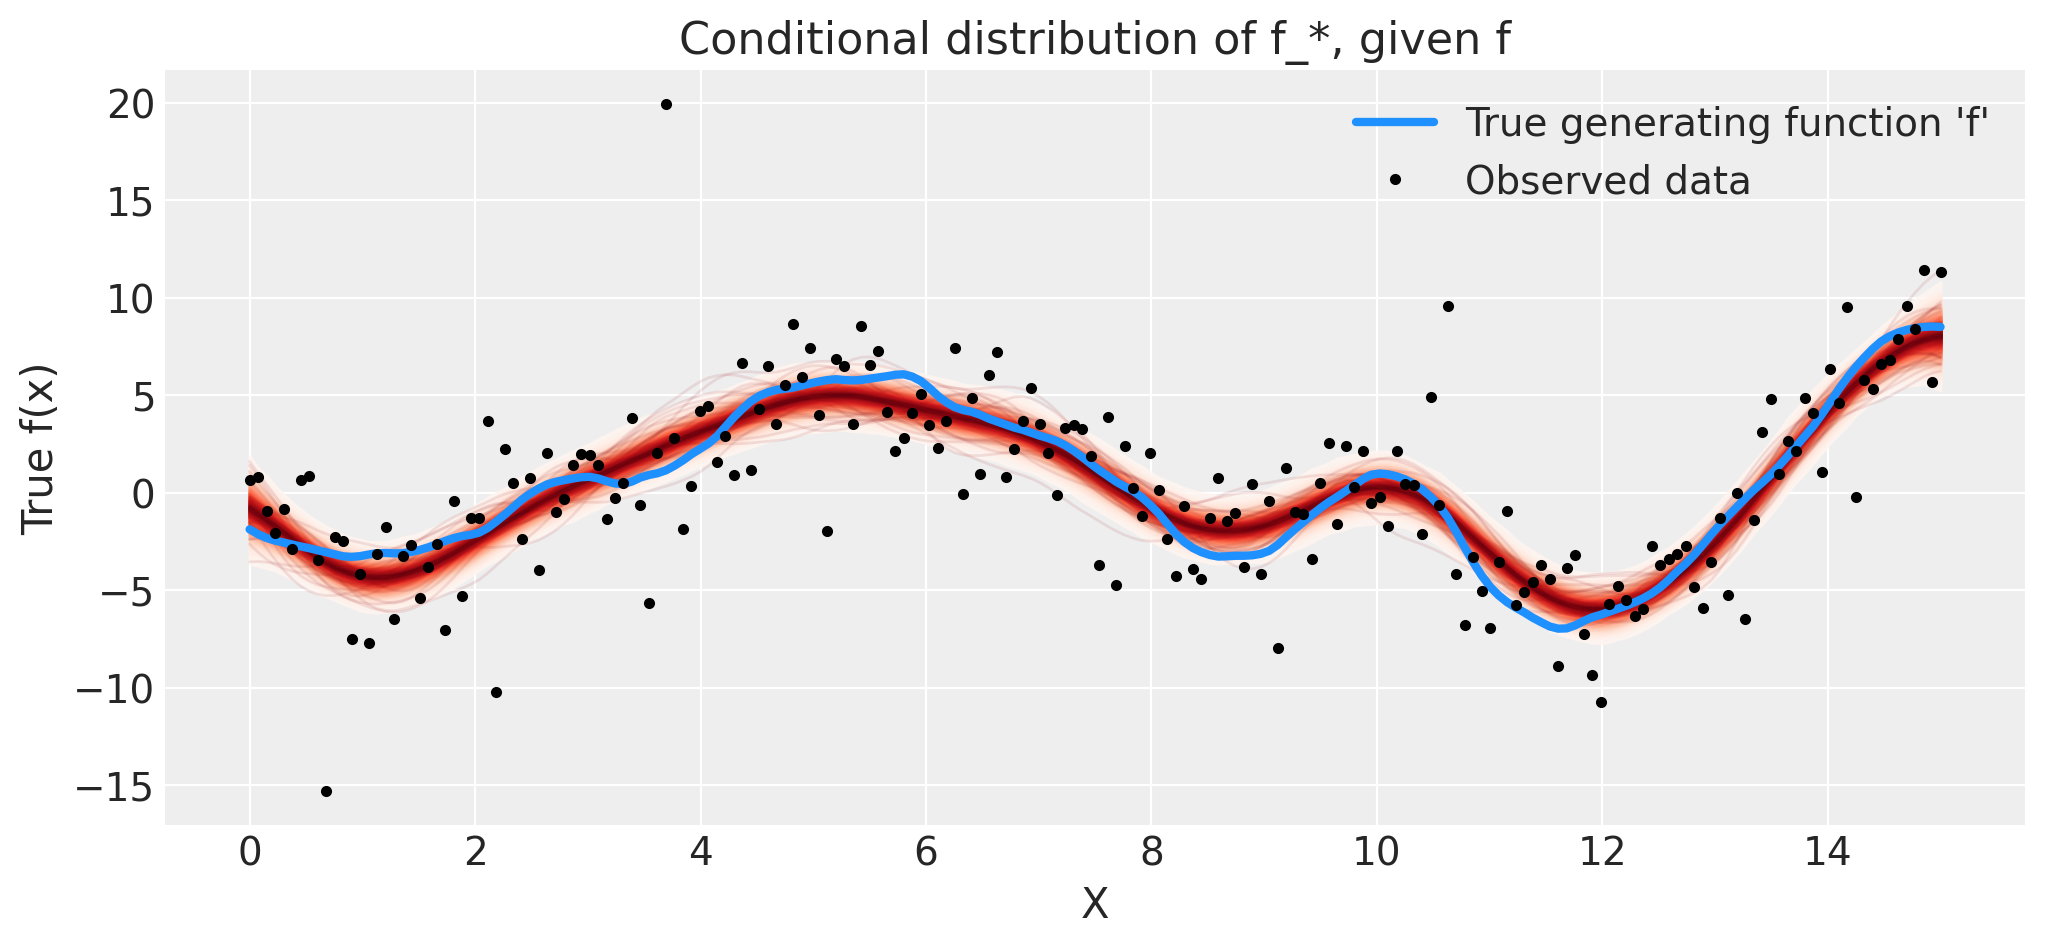

In [150]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f2_pred"], X_new)

ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

ax.set_xlabel("X")
ax.set_ylabel("True f(x)")
ax.set_title("Conditional distribution of f_*, given f")
plt.legend()

In [151]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=2000)

<AxesSubplot:>

Text(0.5, 0, 'x')

(-13.0, 13.0)

Text(0.5, 1.0, 'posterior predictive distribution, y_*')

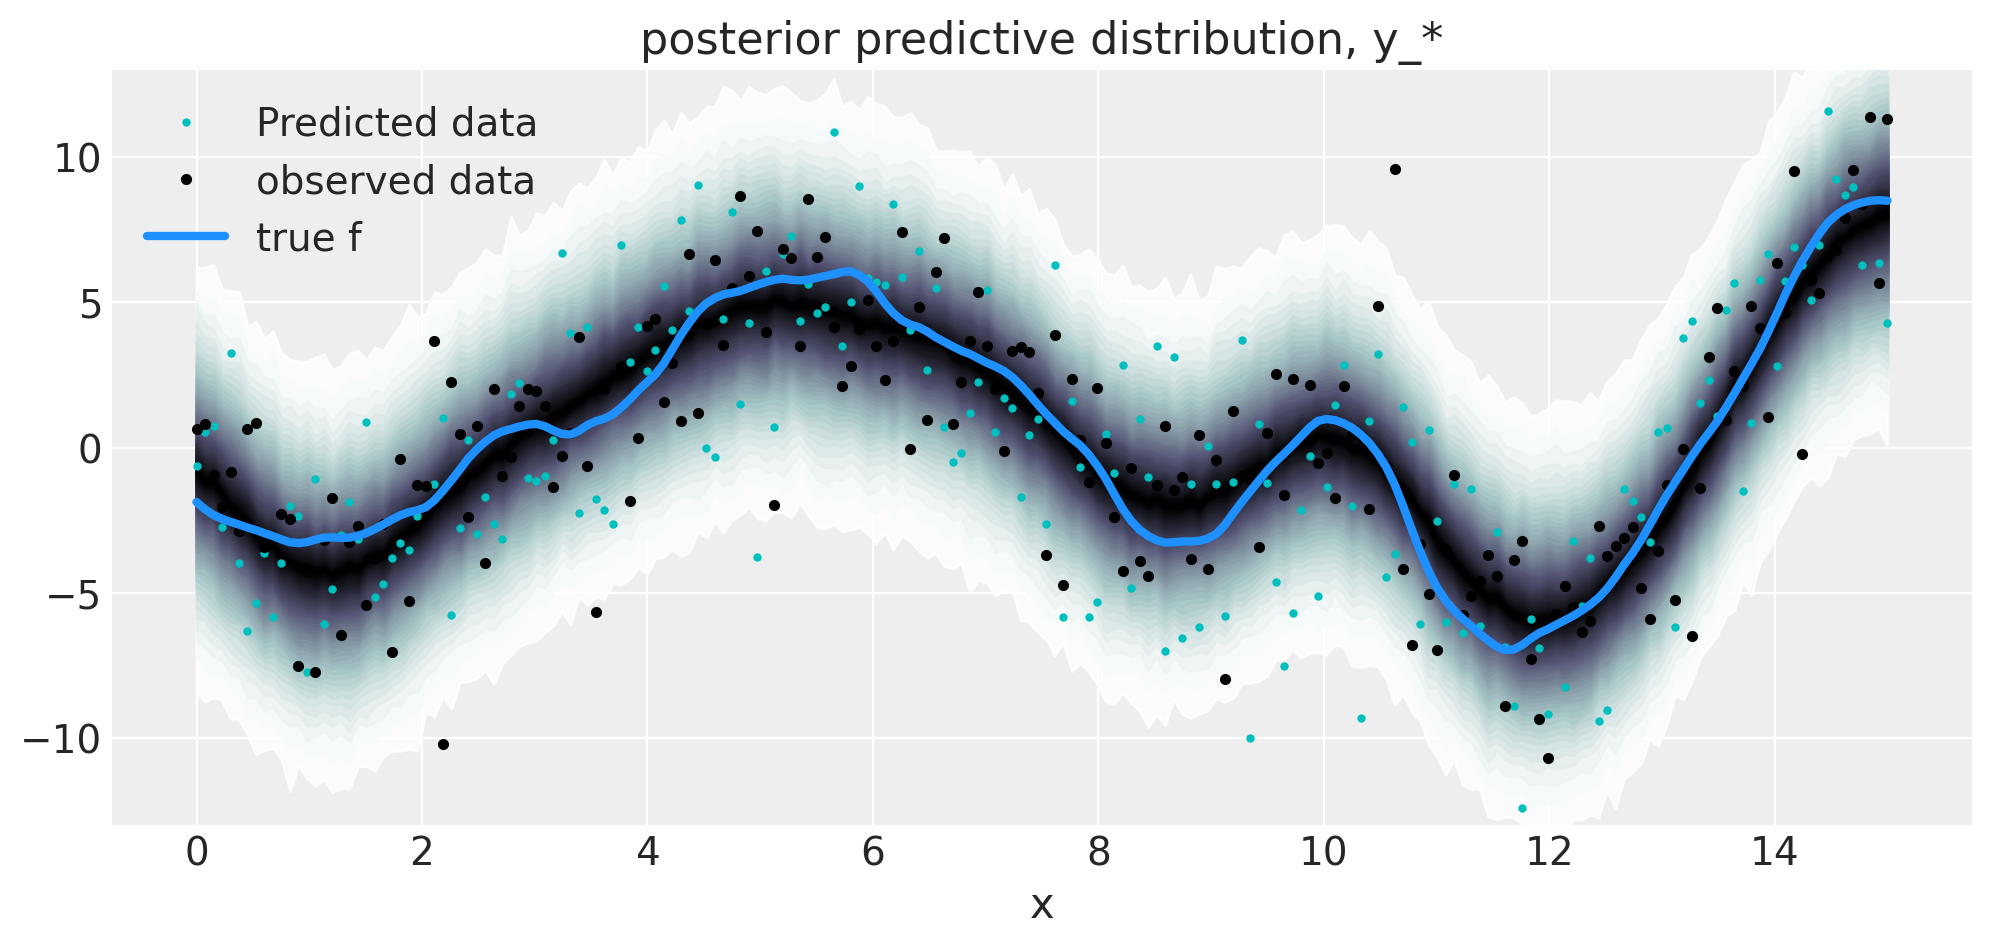

In [152]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="bone_r")

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][800, :].T, "co", ms=2, label="Predicted data")

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("posterior predictive distribution, y_*")
plt.legend()

Text(0.5, 0, 'x')

(-13.0, 13.0)

Text(0.5, 1.0, 'predictive mean and 2σ interval')

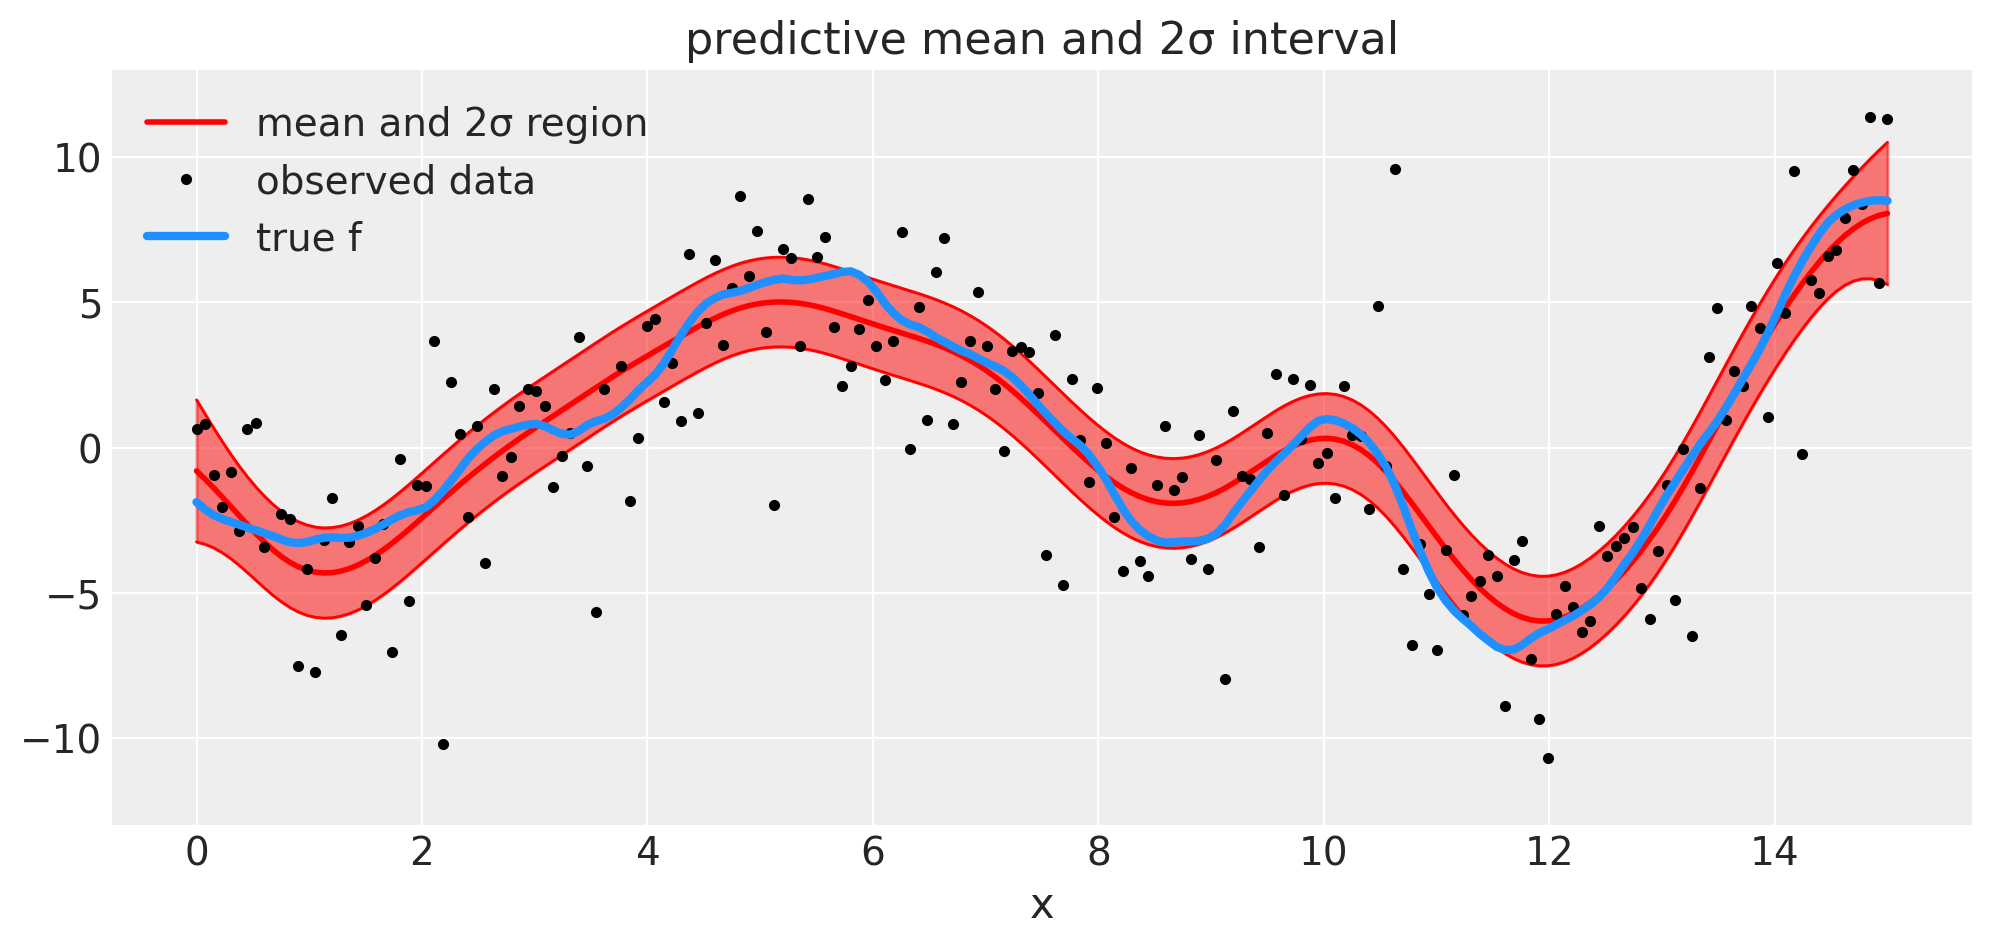

In [153]:
# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(X_new, mu + 2 * sd, "r", lw=1)
plt.plot(X_new, mu - 2 * sd, "r", lw=1)
plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("predictive mean and 2σ interval")
plt.legend()

---

Credit:

The original notebook outling all of the steps above can be found [here](https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Latent.html) and [here](https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Marginal.html) on the PyMC3 webste